In [13]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
''' Activation Functions '''

def relu(x, p=False):
    if p: return 1 * (x > 0)
    return x * (x > 0)

def linear(x, p=False):
    if p: return np.ones_like(x)
    return x

In [3]:
''' Cost Functions '''

def MSE(output_acts, y, p=False):
    if p: return (output_acts-y)
    return 0.5*(output_acts-y)**2

In [35]:
''' Optimization Functions '''

def sgd(lr, nabla, cache, alpha=0.9, nasterov=False):
    cache = [alpha*c - lr*n for n, c in zip(nabla, cache)]
    update = [-lr*n for n in nabla] if nasterov else cache.copy()
    return cache, update

In [32]:
''' Learning Rate Schedulers '''

def constant(lr, epoch):
    return lr

def time_decay(lr, epoch, decay_rate):
    return lr / (1. + decay_rate*epoch)

def exp_decay(lr, epoch, decay_rate):
    return lr * np.exp(-epoch*decay_rate)

def step_decay(lr, epoch, decay_rate, decay_step):
    return lr * decay_rate**(np.floor(epoch/decay_step))

In [36]:
''' Network Class '''

class Network:

    def __init__(self, s=43):
        np.random.seed(s)
        self.layer_cnt = 0
        self.weights = []
        self.biases = []
        self.act_funcs = []
        self.report = dict()
        self.report['loss'] = []
        self.report['re'] = []

    def dense(self, neuron_cnt, act_func, input_shape=None):
        if self.layer_cnt == 0 and (not input_shape):
            raise Exception('First Layer Must Have Input Shape')

        self.layer_cnt += 1

        if self.layer_cnt == 1:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, input_shape)))
        else:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, self.weights[-1].shape[0])))

        self.biases.append(np.zeros((neuron_cnt, 1)))
        self.act_funcs.append(act_func)

    def feedforward(self, x):
        pre_acts, acts = [], []
        act = np.array(x)

        acts.append(act)

        for w, b, a in zip(self.weights, self.biases, self.act_funcs):
            pre_act = np.dot(w, act) + b
            act = a(pre_act)
            pre_acts.append(pre_act)
            acts.append(act)

        return pre_acts, acts, act

    def backprop(self, x, y, cost_func):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        pre_acts, acts, out = self.feedforward(x)

        delta = cost_func(acts[-1], y, p=True) * self.act_funcs[-1](pre_acts[-1], p=True)
        nabla_w[-1] = np.dot(delta, acts[-2].T)
        nabla_b[-1] = delta

        for i in range(2, self.layer_cnt+1):
            delta = np.dot(self.weights[-i+1].T, delta) * self.act_funcs[-i](pre_acts[-i], p=True)
            nabla_w[-i] = np.dot(delta, acts[-i-1].T)
            nabla_b[-i] = delta

        return nabla_w, nabla_b, out

    def next_mini_batch(self, dataset, batch_size):
        N = dataset['count']
        indxs = np.arange(N)
        np.random.shuffle(indxs)

        for i in range(0, N-batch_size+1, batch_size):
            mini_batch = indxs[i:i+batch_size]
            yield zip(dataset['X'][mini_batch], dataset['y'][mini_batch])

    def learn(self, cost_func, epochs, dataset,
            optimizer, lr_schedulers, nasterov=False,
            eta=0.001, alpha=0.9, batch_size=32, verbos=1):

        for i in tqdm(range(epochs), disable=(not verbos)):
            eta_ = lr_schedulers(eta, i)
            lr = eta_/batch_size

            cache_b = [np.zeros(b.shape) for b in self.biases]
            cache_w = [np.zeros(w.shape) for w in self.weights]
            y_, y_h = [], []

            for mini_batch in self.next_mini_batch(dataset, batch_size):
                nabla_b = [np.zeros(b.shape) for b in self.biases]
                nabla_w = [np.zeros(w.shape) for w in self.weights]

                if nasterov:
                    self.biases = [b + alpha*c for b, c in zip(self.biases, cache_b)]
                    self.weights = [w + alpha*c for w, c in zip(self.weights, cache_w)]

                for x, y in mini_batch:
                    delta_nabla_w, delta_nabla_b, out = self.backprop(x, y, cost_func)
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] 
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                    y_.append(y)
                    y_h.append(out)

                cache_b, update_b = optimizer(lr, nabla_b, cache_b)
                self.biases = [b+nb for b, nb in zip(self.biases, update_b)]
                cache_w, update_w = optimizer(lr, nabla_w, cache_w)
                self.weights = [w+nw for w, nw in zip(self.weights, update_w)]

            y_, y_h = np.array(y_).ravel(), np.array(y_h).ravel()
            self.report['loss'].append(np.mean(cost_func(y_h, y_)))
            self.report['re'].append(np.mean(np.abs((y_h-y_)/y_)))

            if verbos == 1:
                print('loss: ', self.report['loss'][-1],
                      'reletive error: ', self.report['re'][-1])

    def reset(self):
        self.biases = [np.random.rand(*b.shape) for b in self.biases]
        self.weights = [np.random.rand(*w.shape) for w in self.weights]
        self.report['loss'] = []
        self.report['re'] = []

In [6]:
''' Dataset Functions '''

def make_dataset(N):
    dataset = dict()
    dataset['count'] = N
    dataset['X'] = np.random.uniform(-1, 1, (N, 10, 1))
    dataset['y'] = np.sin(np.mean(dataset['X'][:, :5], axis=1)) + \
                    np.cos(np.mean(dataset['X'][:, 5:], axis=1))

    return dataset


  2%|▏         | 1/50 [00:00<00:41,  1.17it/s]

loss:  13.595458681449918 reletive error:  0.6892003289521935



  4%|▍         | 2/50 [00:01<00:41,  1.16it/s]

loss:  0.03291485970581074 reletive error:  0.22572499929409964



  6%|▌         | 3/50 [00:02<00:40,  1.15it/s]

loss:  0.029234648252004558 reletive error:  0.2259158806298033



  8%|▊         | 4/50 [00:03<00:40,  1.14it/s]

loss:  0.02764303485725144 reletive error:  0.2245356520407465



 10%|█         | 5/50 [00:04<00:39,  1.15it/s]

loss:  0.02657020701269596 reletive error:  0.22244011236370903



 12%|█▏        | 6/50 [00:05<00:38,  1.15it/s]

loss:  0.02571018756430023 reletive error:  0.21920189753120062



 14%|█▍        | 7/50 [00:06<00:37,  1.15it/s]

loss:  0.02509177544165027 reletive error:  0.21748686405648732



 16%|█▌        | 8/50 [00:07<00:36,  1.14it/s]

loss:  0.024560682844484875 reletive error:  0.21613856458009195



 18%|█▊        | 9/50 [00:07<00:36,  1.14it/s]

loss:  0.02407347786784184 reletive error:  0.21421431899369253



 20%|██        | 10/50 [00:08<00:35,  1.13it/s]

loss:  0.02369180783508703 reletive error:  0.21289359774007707



 22%|██▏       | 11/50 [00:09<00:35,  1.11it/s]

loss:  0.023328153335571138 reletive error:  0.2118059993418079



 24%|██▍       | 12/50 [00:10<00:34,  1.10it/s]

loss:  0.023013147120438223 reletive error:  0.21041440012976295



 26%|██▌       | 13/50 [00:11<00:33,  1.11it/s]

loss:  0.022723667295060927 reletive error:  0.20934944303596112



 28%|██▊       | 14/50 [00:12<00:32,  1.11it/s]

loss:  0.02245868513276829 reletive error:  0.20826223140017064



 30%|███       | 15/50 [00:13<00:31,  1.11it/s]

loss:  0.02217939025091716 reletive error:  0.20719835821651195



 32%|███▏      | 16/50 [00:14<00:30,  1.11it/s]

loss:  0.021948228991062246 reletive error:  0.20638395243611385



 34%|███▍      | 17/50 [00:15<00:29,  1.11it/s]

loss:  0.021695930382177455 reletive error:  0.20543506645017137



 36%|███▌      | 18/50 [00:16<00:28,  1.11it/s]

loss:  0.021502572716871206 reletive error:  0.2045471057658821



 38%|███▊      | 19/50 [00:16<00:27,  1.11it/s]

loss:  0.021302921340050796 reletive error:  0.203708521348529



 40%|████      | 20/50 [00:17<00:26,  1.12it/s]

loss:  0.02108696903134766 reletive error:  0.20302616052602862



 42%|████▏     | 21/50 [00:18<00:25,  1.12it/s]

loss:  0.02090949868928272 reletive error:  0.20226710581170976



 44%|████▍     | 22/50 [00:19<00:24,  1.13it/s]

loss:  0.02070524315915951 reletive error:  0.2016606640811357



 46%|████▌     | 23/50 [00:20<00:24,  1.11it/s]

loss:  0.020519494269455107 reletive error:  0.20056415486094276



 48%|████▊     | 24/50 [00:21<00:23,  1.12it/s]

loss:  0.020354125750418187 reletive error:  0.19967141730924046



 50%|█████     | 25/50 [00:22<00:22,  1.13it/s]

loss:  0.02016084681457792 reletive error:  0.19862266843423862



 52%|█████▏    | 26/50 [00:23<00:21,  1.12it/s]

loss:  0.019960137436027793 reletive error:  0.19834336795332874



 54%|█████▍    | 27/50 [00:24<00:20,  1.13it/s]

loss:  0.01979074925204352 reletive error:  0.1974913869628609



 56%|█████▌    | 28/50 [00:24<00:19,  1.13it/s]

loss:  0.019628246917267337 reletive error:  0.1969324681886716



 58%|█████▊    | 29/50 [00:25<00:18,  1.12it/s]

loss:  0.019447702998541976 reletive error:  0.19600294720973788



 60%|██████    | 30/50 [00:26<00:17,  1.13it/s]

loss:  0.019292923450636917 reletive error:  0.19490368415621842



 62%|██████▏   | 31/50 [00:27<00:16,  1.12it/s]

loss:  0.019118177607207916 reletive error:  0.1942776826587803



 64%|██████▍   | 32/50 [00:28<00:15,  1.13it/s]

loss:  0.018949781770081286 reletive error:  0.1935535540535117



 66%|██████▌   | 33/50 [00:29<00:15,  1.10it/s]

loss:  0.018780337392257637 reletive error:  0.19267685077639235



 68%|██████▊   | 34/50 [00:30<00:14,  1.12it/s]

loss:  0.018630457222166337 reletive error:  0.19202334075426114



 70%|███████   | 35/50 [00:31<00:13,  1.12it/s]

loss:  0.01846889737584764 reletive error:  0.1913967103448917



 72%|███████▏  | 36/50 [00:32<00:12,  1.12it/s]

loss:  0.01830813922295838 reletive error:  0.19090286965540823



 74%|███████▍  | 37/50 [00:32<00:11,  1.12it/s]

loss:  0.018152248830457556 reletive error:  0.18972092600100687



 76%|███████▌  | 38/50 [00:33<00:10,  1.12it/s]

loss:  0.018002282615382087 reletive error:  0.18908932255813446



 78%|███████▊  | 39/50 [00:34<00:09,  1.11it/s]

loss:  0.01784285837038965 reletive error:  0.18838265432535894



 80%|████████  | 40/50 [00:35<00:08,  1.12it/s]

loss:  0.01768711422363244 reletive error:  0.18757091324124994



 82%|████████▏ | 41/50 [00:36<00:07,  1.14it/s]

loss:  0.017539973446997578 reletive error:  0.18700202469322438



 84%|████████▍ | 42/50 [00:37<00:07,  1.14it/s]

loss:  0.017398121935736397 reletive error:  0.1863630843651707



 86%|████████▌ | 43/50 [00:38<00:06,  1.13it/s]

loss:  0.017241248809349994 reletive error:  0.18546792885591723



 88%|████████▊ | 44/50 [00:39<00:05,  1.14it/s]

loss:  0.01708135735128936 reletive error:  0.18459781904704392



 90%|█████████ | 45/50 [00:40<00:04,  1.14it/s]

loss:  0.016934073220889977 reletive error:  0.18387846441825514



 92%|█████████▏| 46/50 [00:40<00:03,  1.14it/s]

loss:  0.016790290673775018 reletive error:  0.18313081070513448



 94%|█████████▍| 47/50 [00:41<00:02,  1.13it/s]

loss:  0.016646335983287484 reletive error:  0.1824811550781878



 96%|█████████▌| 48/50 [00:42<00:01,  1.13it/s]

loss:  0.0165027270263633 reletive error:  0.18151489735434



 98%|█████████▊| 49/50 [00:43<00:00,  1.12it/s]

loss:  0.016356244685718044 reletive error:  0.1809730188352095



100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

loss:  0.016205344154565027 reletive error:  0.1799238992195102



  2%|▏         | 1/50 [00:00<00:43,  1.13it/s]

loss:  30.956813398632512 reletive error:  0.9356652634930978



  4%|▍         | 2/50 [00:01<00:42,  1.14it/s]

loss:  0.03216098254197188 reletive error:  0.25028020400466994



  6%|▌         | 3/50 [00:02<00:41,  1.14it/s]

loss:  0.032166362328660374 reletive error:  0.24959574434056864



  8%|▊         | 4/50 [00:03<00:39,  1.15it/s]

loss:  0.03216490261869541 reletive error:  0.25015121995647815



 10%|█         | 5/50 [00:04<00:39,  1.15it/s]

loss:  0.032154499457976715 reletive error:  0.24981799429369986



 12%|█▏        | 6/50 [00:05<00:38,  1.15it/s]

loss:  0.03216910989839915 reletive error:  0.24993395473855953



 14%|█▍        | 7/50 [00:06<00:37,  1.13it/s]

loss:  0.03214220988879988 reletive error:  0.25012139944598083



 16%|█▌        | 8/50 [00:06<00:36,  1.14it/s]

loss:  0.03217005287946448 reletive error:  0.24948203767220875



 18%|█▊        | 9/50 [00:07<00:35,  1.14it/s]

loss:  0.03214528825405791 reletive error:  0.2500281996734112



 20%|██        | 10/50 [00:08<00:34,  1.14it/s]

loss:  0.032164878294147 reletive error:  0.2496388972388955



 22%|██▏       | 11/50 [00:09<00:33,  1.15it/s]

loss:  0.03216389327996338 reletive error:  0.24999564712552724



 24%|██▍       | 12/50 [00:10<00:33,  1.15it/s]

loss:  0.03216396056459849 reletive error:  0.24997404922570313



 26%|██▌       | 13/50 [00:11<00:32,  1.15it/s]

loss:  0.03216067716723241 reletive error:  0.24977848957574184



 28%|██▊       | 14/50 [00:12<00:31,  1.14it/s]

loss:  0.03216109907752601 reletive error:  0.24970082856977865



 30%|███       | 15/50 [00:13<00:30,  1.14it/s]

loss:  0.032162810616395206 reletive error:  0.250089415453484



 32%|███▏      | 16/50 [00:13<00:29,  1.15it/s]

loss:  0.03217102620000621 reletive error:  0.2501033630738793



 34%|███▍      | 17/50 [00:14<00:28,  1.16it/s]

loss:  0.032166469965530055 reletive error:  0.2496817385904215



 36%|███▌      | 18/50 [00:15<00:27,  1.16it/s]

loss:  0.03216607340221851 reletive error:  0.24997446389231565



 38%|███▊      | 19/50 [00:16<00:26,  1.16it/s]

loss:  0.03216072824606443 reletive error:  0.24991022233646276



 40%|████      | 20/50 [00:17<00:26,  1.15it/s]

loss:  0.03215941226463437 reletive error:  0.24983510291193806



 42%|████▏     | 21/50 [00:18<00:25,  1.15it/s]

loss:  0.0321667924576488 reletive error:  0.2499211240420596



 44%|████▍     | 22/50 [00:19<00:24,  1.15it/s]

loss:  0.03215762693338438 reletive error:  0.25018762693157376



 46%|████▌     | 23/50 [00:20<00:23,  1.15it/s]

loss:  0.03216186665504168 reletive error:  0.24985153722007827



 48%|████▊     | 24/50 [00:20<00:22,  1.14it/s]

loss:  0.032167019123384884 reletive error:  0.2500206283430214



 50%|█████     | 25/50 [00:21<00:21,  1.14it/s]

loss:  0.03215823383673691 reletive error:  0.24989059853497492



 52%|█████▏    | 26/50 [00:22<00:21,  1.13it/s]

loss:  0.03216318806583573 reletive error:  0.24995630063395283



 54%|█████▍    | 27/50 [00:23<00:20,  1.11it/s]

loss:  0.03216164772311303 reletive error:  0.24961112486105666



 56%|█████▌    | 28/50 [00:24<00:19,  1.11it/s]

loss:  0.03217064190783423 reletive error:  0.25012239371412387



 58%|█████▊    | 29/50 [00:25<00:18,  1.11it/s]

loss:  0.03217106304714101 reletive error:  0.2500159919269897



 60%|██████    | 30/50 [00:26<00:17,  1.12it/s]

loss:  0.03216734763854825 reletive error:  0.24991672484302



 62%|██████▏   | 31/50 [00:27<00:16,  1.12it/s]

loss:  0.032158119133278866 reletive error:  0.2500097502008022



 64%|██████▍   | 32/50 [00:28<00:16,  1.12it/s]

loss:  0.032157174134975604 reletive error:  0.24973702655760066



 66%|██████▌   | 33/50 [00:29<00:15,  1.11it/s]

loss:  0.03216269179928159 reletive error:  0.24979043526098918



 68%|██████▊   | 34/50 [00:29<00:14,  1.11it/s]

loss:  0.032162248065804894 reletive error:  0.25014559176177714



 70%|███████   | 35/50 [00:30<00:13,  1.11it/s]

loss:  0.03215636631841146 reletive error:  0.24980426263211106



 72%|███████▏  | 36/50 [00:31<00:12,  1.11it/s]

loss:  0.032158159968312255 reletive error:  0.2496726833799512



 74%|███████▍  | 37/50 [00:32<00:11,  1.12it/s]

loss:  0.0321702995720812 reletive error:  0.25025607206800143



 76%|███████▌  | 38/50 [00:33<00:10,  1.13it/s]

loss:  0.03216054651851839 reletive error:  0.24987749097703846



 78%|███████▊  | 39/50 [00:34<00:09,  1.13it/s]

loss:  0.032170306275551064 reletive error:  0.2500384762912734



 80%|████████  | 40/50 [00:35<00:08,  1.14it/s]

loss:  0.03216403295730008 reletive error:  0.24993807016520253



 82%|████████▏ | 41/50 [00:36<00:07,  1.15it/s]

loss:  0.032162412151575996 reletive error:  0.2499312540606326



 84%|████████▍ | 42/50 [00:36<00:06,  1.15it/s]

loss:  0.03216306639319195 reletive error:  0.2498719595557866



 86%|████████▌ | 43/50 [00:37<00:06,  1.15it/s]

loss:  0.032164184368143715 reletive error:  0.2500608969868236



 88%|████████▊ | 44/50 [00:38<00:05,  1.15it/s]

loss:  0.0321603798137627 reletive error:  0.24970005883394641



 90%|█████████ | 45/50 [00:39<00:04,  1.14it/s]

loss:  0.03216358674411989 reletive error:  0.24995774689146466



 92%|█████████▏| 46/50 [00:40<00:03,  1.14it/s]

loss:  0.032161711972430264 reletive error:  0.24988573715897247



 94%|█████████▍| 47/50 [00:41<00:02,  1.13it/s]

loss:  0.03216945083143276 reletive error:  0.2504799739157529



 96%|█████████▌| 48/50 [00:42<00:01,  1.13it/s]

loss:  0.032159981539133034 reletive error:  0.24977134386317768



 98%|█████████▊| 49/50 [00:43<00:00,  1.14it/s]

loss:  0.03215815713095284 reletive error:  0.24991591939436886



100%|██████████| 50/50 [00:43<00:00,  1.14it/s]

loss:  0.03215891394436434 reletive error:  0.2498266911108667


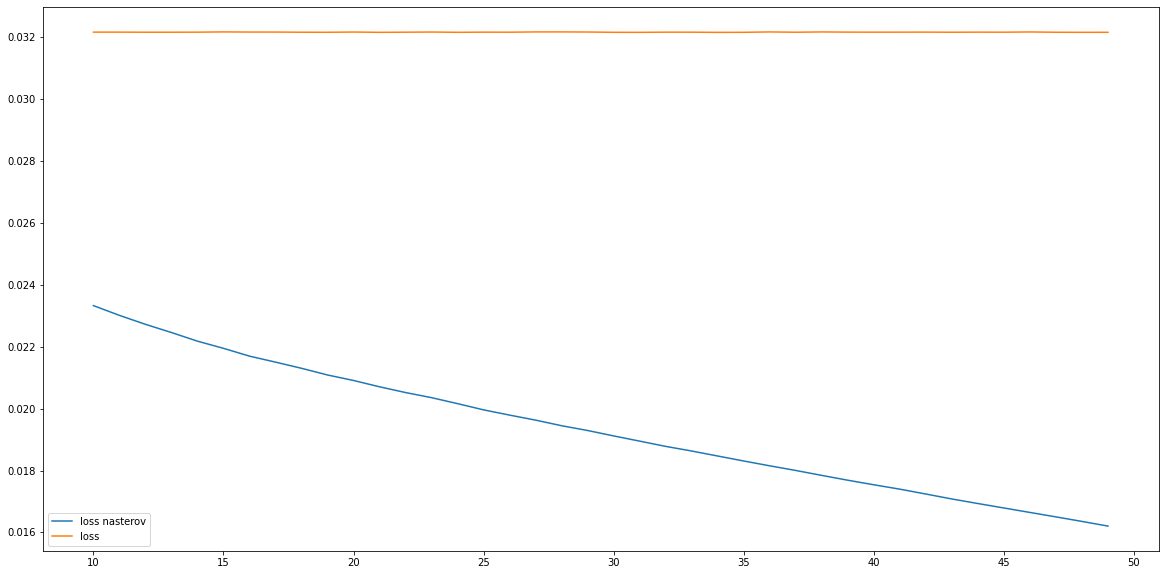

In [38]:
mynet = Network()

mynet.dense(16, relu, 10)
mynet.dense(32, relu)
mynet.dense(1, linear)

mydata = make_dataset(10000)
x = np.arange(10, 50)

optimizer = lambda lr, nabla, cache: sgd(lr, nabla, cache, alpha=0.9, nasterov=True)

lr_schedulers = lambda lr, epoch: constant(lr, epoch)

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers, nasterov=True,
            eta=0.0002, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss nasterov")

optimizer = lambda lr, nabla, cache: sgd(lr, nabla, cache, alpha=0.9, nasterov=False)

mynet.reset()
mynet.learn(MSE, 50, mydata, optimizer, lr_schedulers, nasterov=False,
            eta=0.0002, batch_size=16, alpha=0.9, verbos=1)
plt.plot(x, mynet.report['loss'][10:], label="loss")


plt.legend()
plt.show()